In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

# Path to your ZIP file
data_zip_path = "/content/drive/MyDrive/data.zip"

# Destination folder to extract the ZIP file to (you can choose any path)
extract_to = "/content/drive/MyDrive/Classroom/data"

# Extract the ZIP file
with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted files to: {extract_to}")

Extracted files to: /content/drive/MyDrive/Classroom/data


In [3]:
pip install pylibtiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylibtiff: filename=pylibtiff-0.6.1-cp310-cp310-linux_x86_64.whl size=202907 sha256=55639ca6027563d1c58ec6cf279cbcd0268e1ac6a1f2f0084443983f56cc6154
  Stored in directory: /root/.cache/pip/wheels/18/3a/a4/2fecac4e3bf7f84b3cac4d79f138869401b18dde7a3f07e591
Successfully built pylibtiff


In [4]:
pip install dask_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 20.7 MB/s eta 0:00:00
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84590 sha256=44c680c26344d511e96868b19665c004c02f1e8392b01cfc988df211141975a1
  Stored in directory: /root/.cache/pip/wheels/54/cb/f1/939f4adc0c5bcb1a1a78566d67869368d3d8dc8abd84f63c38
Successfully built pims


In [5]:
pip install cmocean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 25.0 MB/s eta 0:00:00


In [6]:
import cv2
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from libtiff import TIFF
import tensorflow as tf
from keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
images_path = '/content/drive/MyDrive/Classroom/data/data/images'
masks_path = '/content/drive/MyDrive/Classroom/data/data/labels'
img_paths = os.listdir(images_path)
mask_paths = os.listdir(masks_path)

# -> prepare data & data augmantation

In [7]:
images = []
labels = []

for img_path in img_paths:
    tiff = TIFF.open(os.path.join(images_path, img_path))
    img = tiff.read_image()
    images.append(img[:, :, 1:4]) # change number 0 to 1:4 to get the rgb version of image
    mask = plt.imread(os.path.join(masks_path, img_path.replace('.tif', '.png')))
    mask = np.where(mask > 0, 1, 0)
    labels.append(mask)

images = np.array(images)
labels = np.array(labels)

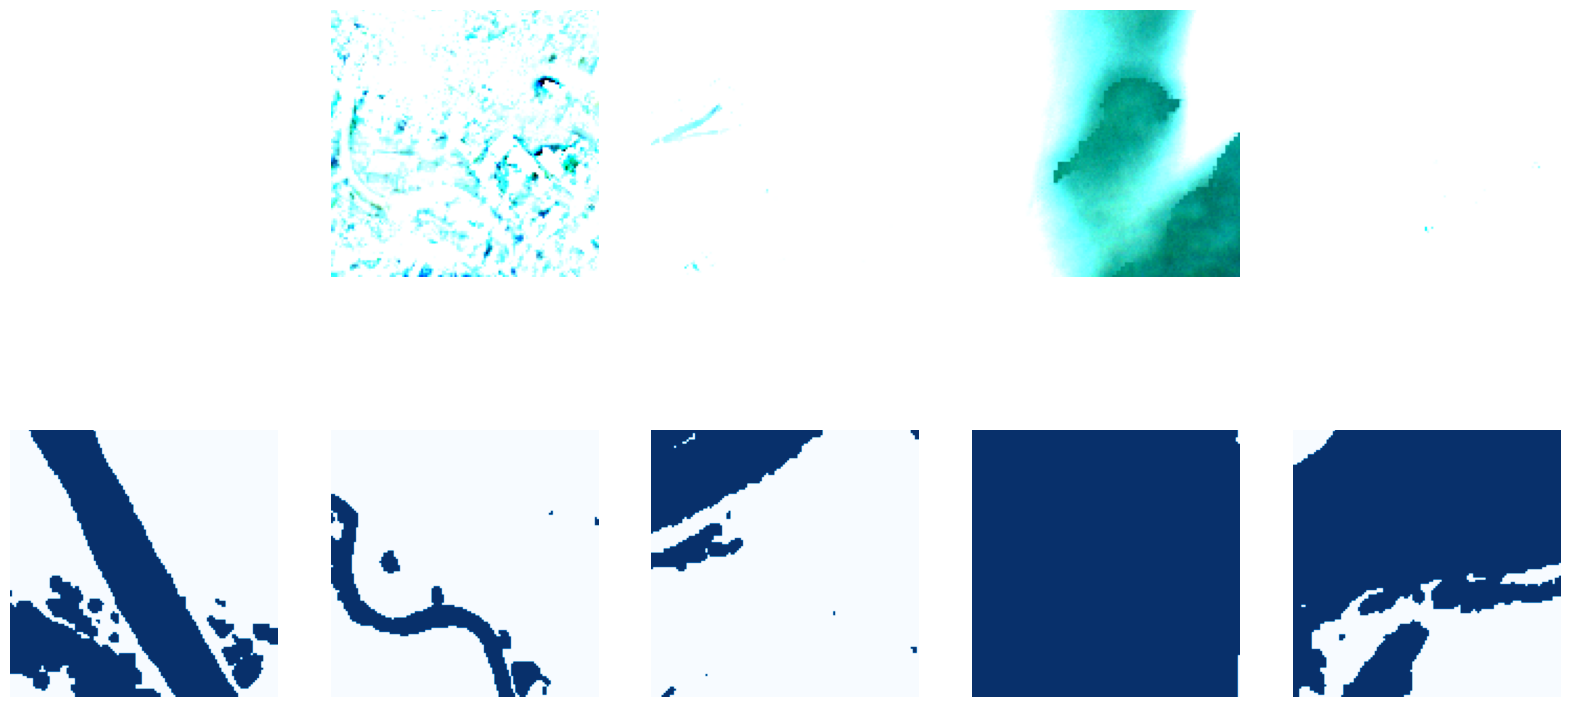

In [8]:
import matplotlib.pyplot as plt
import cmocean
# Select 5 images and masks
img_samples = images[:5]
mask_samples = labels[:5]
img_samples_normalized = img_samples / 255.0

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

# Display images and masks
for i in range(5):
    axs[0, i].imshow(img_samples_normalized[i],cmap=cmocean.cm.topo)
    axs[0, i].axis('off')
    axs[1, i].imshow(mask_samples[i], cmap='Blues')
    axs[1, i].axis('off')

plt.show()

In [9]:
def augment_images_with_labels(images, labels, num_augmented_per_image=5):

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
    )

    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):

        img = np.expand_dims(img, 0)
        label = np.expand_dims(label, 0)

        seed = np.random.randint(1e6)

        img_gen = datagen.flow(img, batch_size=1, seed=seed)
        label_gen = datagen.flow(np.expand_dims(label, axis=-1), batch_size=1, seed=seed)

        for _ in range(num_augmented_per_image):
            augmented_img = next(img_gen)[0]
            augmented_label = next(label_gen)[0].squeeze(-1)

            augmented_images.append(augmented_img)
            augmented_labels.append(augmented_label)

    all_images = np.concatenate((images, np.array(augmented_images)), axis=0)
    all_labels = np.concatenate((labels, np.array(augmented_labels)), axis=0)

    return all_images, all_labels

In [10]:
images, labels = augment_images_with_labels(images, labels)
images.shape, labels.shape

((1836, 128, 128, 3), (1836, 128, 128))

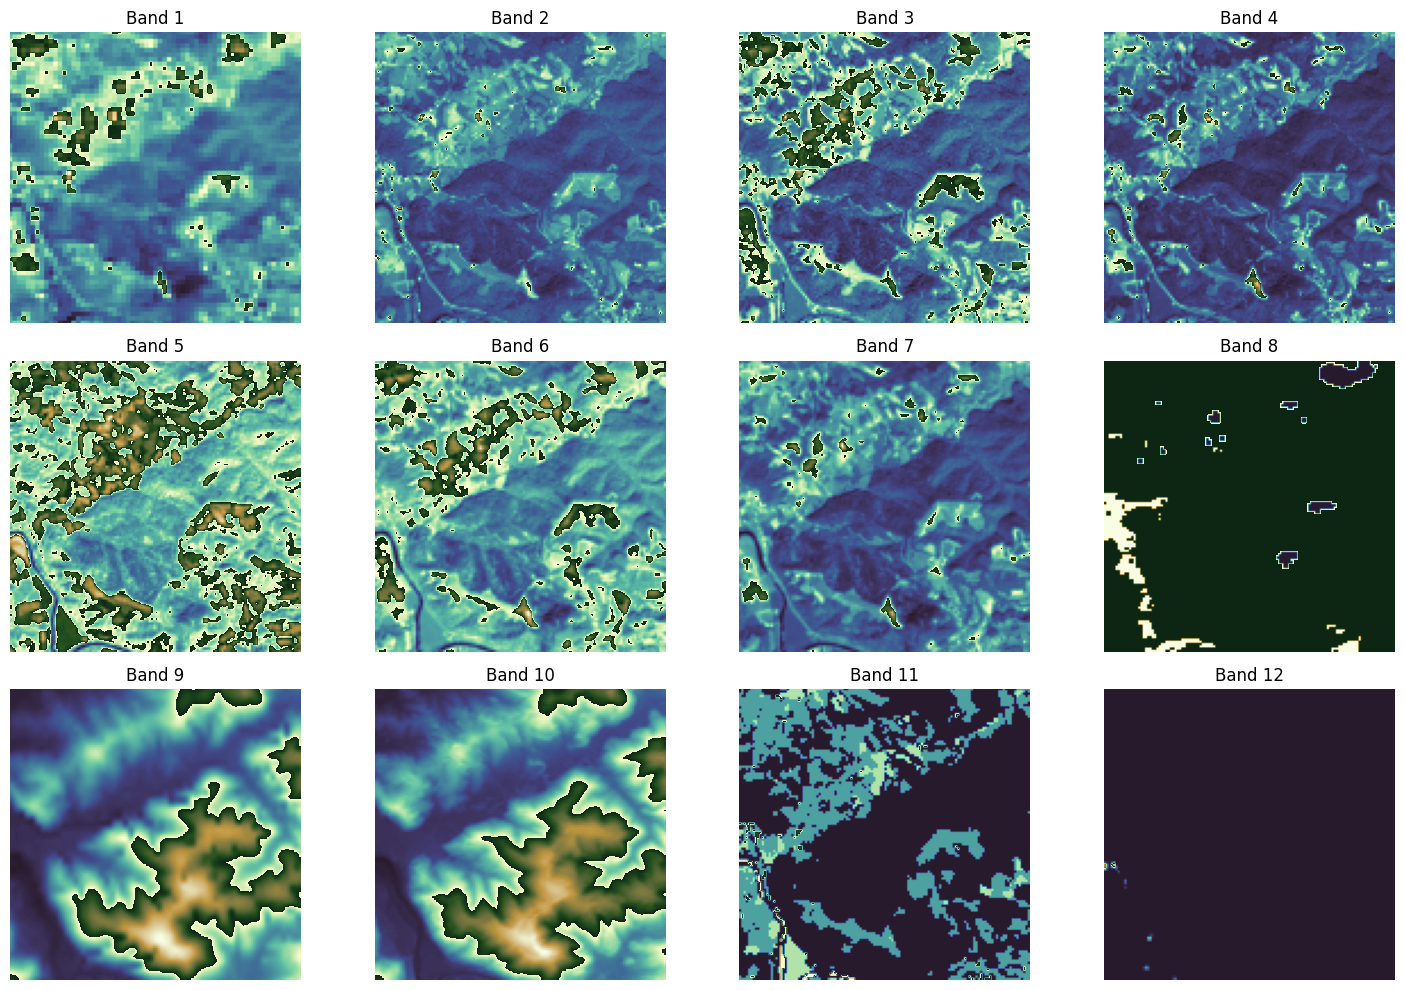

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import dask_image
import dask_image.imread

# Assume that X is the NumPy array containing the 12-channel images
# with shape (num_images, height, width, 12)

# Select a single image from the array
image = dask_image.imread.imread("/content/drive/MyDrive/Classroom/data/data/images/1.tif")

# Create a figure with 12 subplots
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Iterate over each band and visualize it
for i in range(12):
    band = image[0, :, :, i]  # Select a specific channel
    axs[i // 4, i % 4].imshow(band, cmap=cmocean.cm.topo)  # Use a more colorful colormap
    axs[i // 4, i % 4].set_title(f'Band {i+1}')
    axs[i // 4, i % 4].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

In [12]:
X_train, X_test, y_train, Y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# building autoencoder model using MobilNet

In [13]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [14]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='best_model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [15]:
from tensorflow.keras.utils import to_categorical

# Convert y_train and y_val to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

print(y_train.shape)  # Should be (1285, 128, 128, 2)
print(y_val.shape)    # Should be (validation_size, 128, 128, 2)

(1285, 128, 128, 2)
(275, 128, 128, 2)


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input

# Load DenseNet121 with pretrained ImageNet weights
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Create a DeepLabV3+ style segmentation model
def create_deeplabv3plus(num_classes):
    inputs = Input(shape=(128, 128, 3))

    # Base model (DenseNet121) feature extraction
    base_model_output = base_model(inputs)

    # Add additional layers to build the segmentation head
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(base_model_output)
    x = layers.BatchNormalization()(x)

    # Use Conv2DTranspose for upsampling
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Upsample to 8x8
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Upsample to 16x16
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Upsample to 32x32
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Upsample to 64x64
    x = layers.Conv2DTranspose(num_classes, (3, 3), strides=(2, 2), padding='same', activation='softmax')(x)  # Final output to 128x128

    # Define the full model
    model = models.Model(inputs=inputs, outputs=x)

    return model

# Initialize the model
num_classes = 2  # Binary segmentation with 2 classes
model = create_deeplabv3plus(num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 4, 4, 256)           │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 128, 128, 2)         │             290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,790,290 (37.35 MB)

 Trainable params: 9,706,130 (37.03 MB)

 Non-trainable params: 84,160 (328.75 KB)

In [17]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[checkpoint_callback])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5552 - loss: 0.6928   
Epoch 1: val_accuracy improved from -inf to 0.71117, saving model to best_model_weights.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.5566 - loss: 0.6928 - val_accuracy: 0.7112 - val_loss: 0.6888
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6551 - loss: 0.6656
Epoch 2: val_accuracy improved from 0.71117 to 0.76011, saving model to best_model_weights.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 175ms/step - accuracy: 0.6554 - loss: 0.6647 - val_accuracy: 0.7601 - val_loss: 0.4813
Epoch 3/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7276 - loss: 0.4511
Epoch 3: val_accuracy improved from 0.76011 to 0.77493, saving model to best_model_weights.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7284 - loss: 0.4493 - val_accuracy: 0.7749 - val_loss: 0.3894
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7392 - loss: 0.3572
Ep

# visualize model results

In [19]:
y_test = to_categorical(y_test, num_classes=2)
model.evaluate(X_test,y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9350 - loss: 0.1505


[0.15006887912750244, 0.9348706007003784]

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


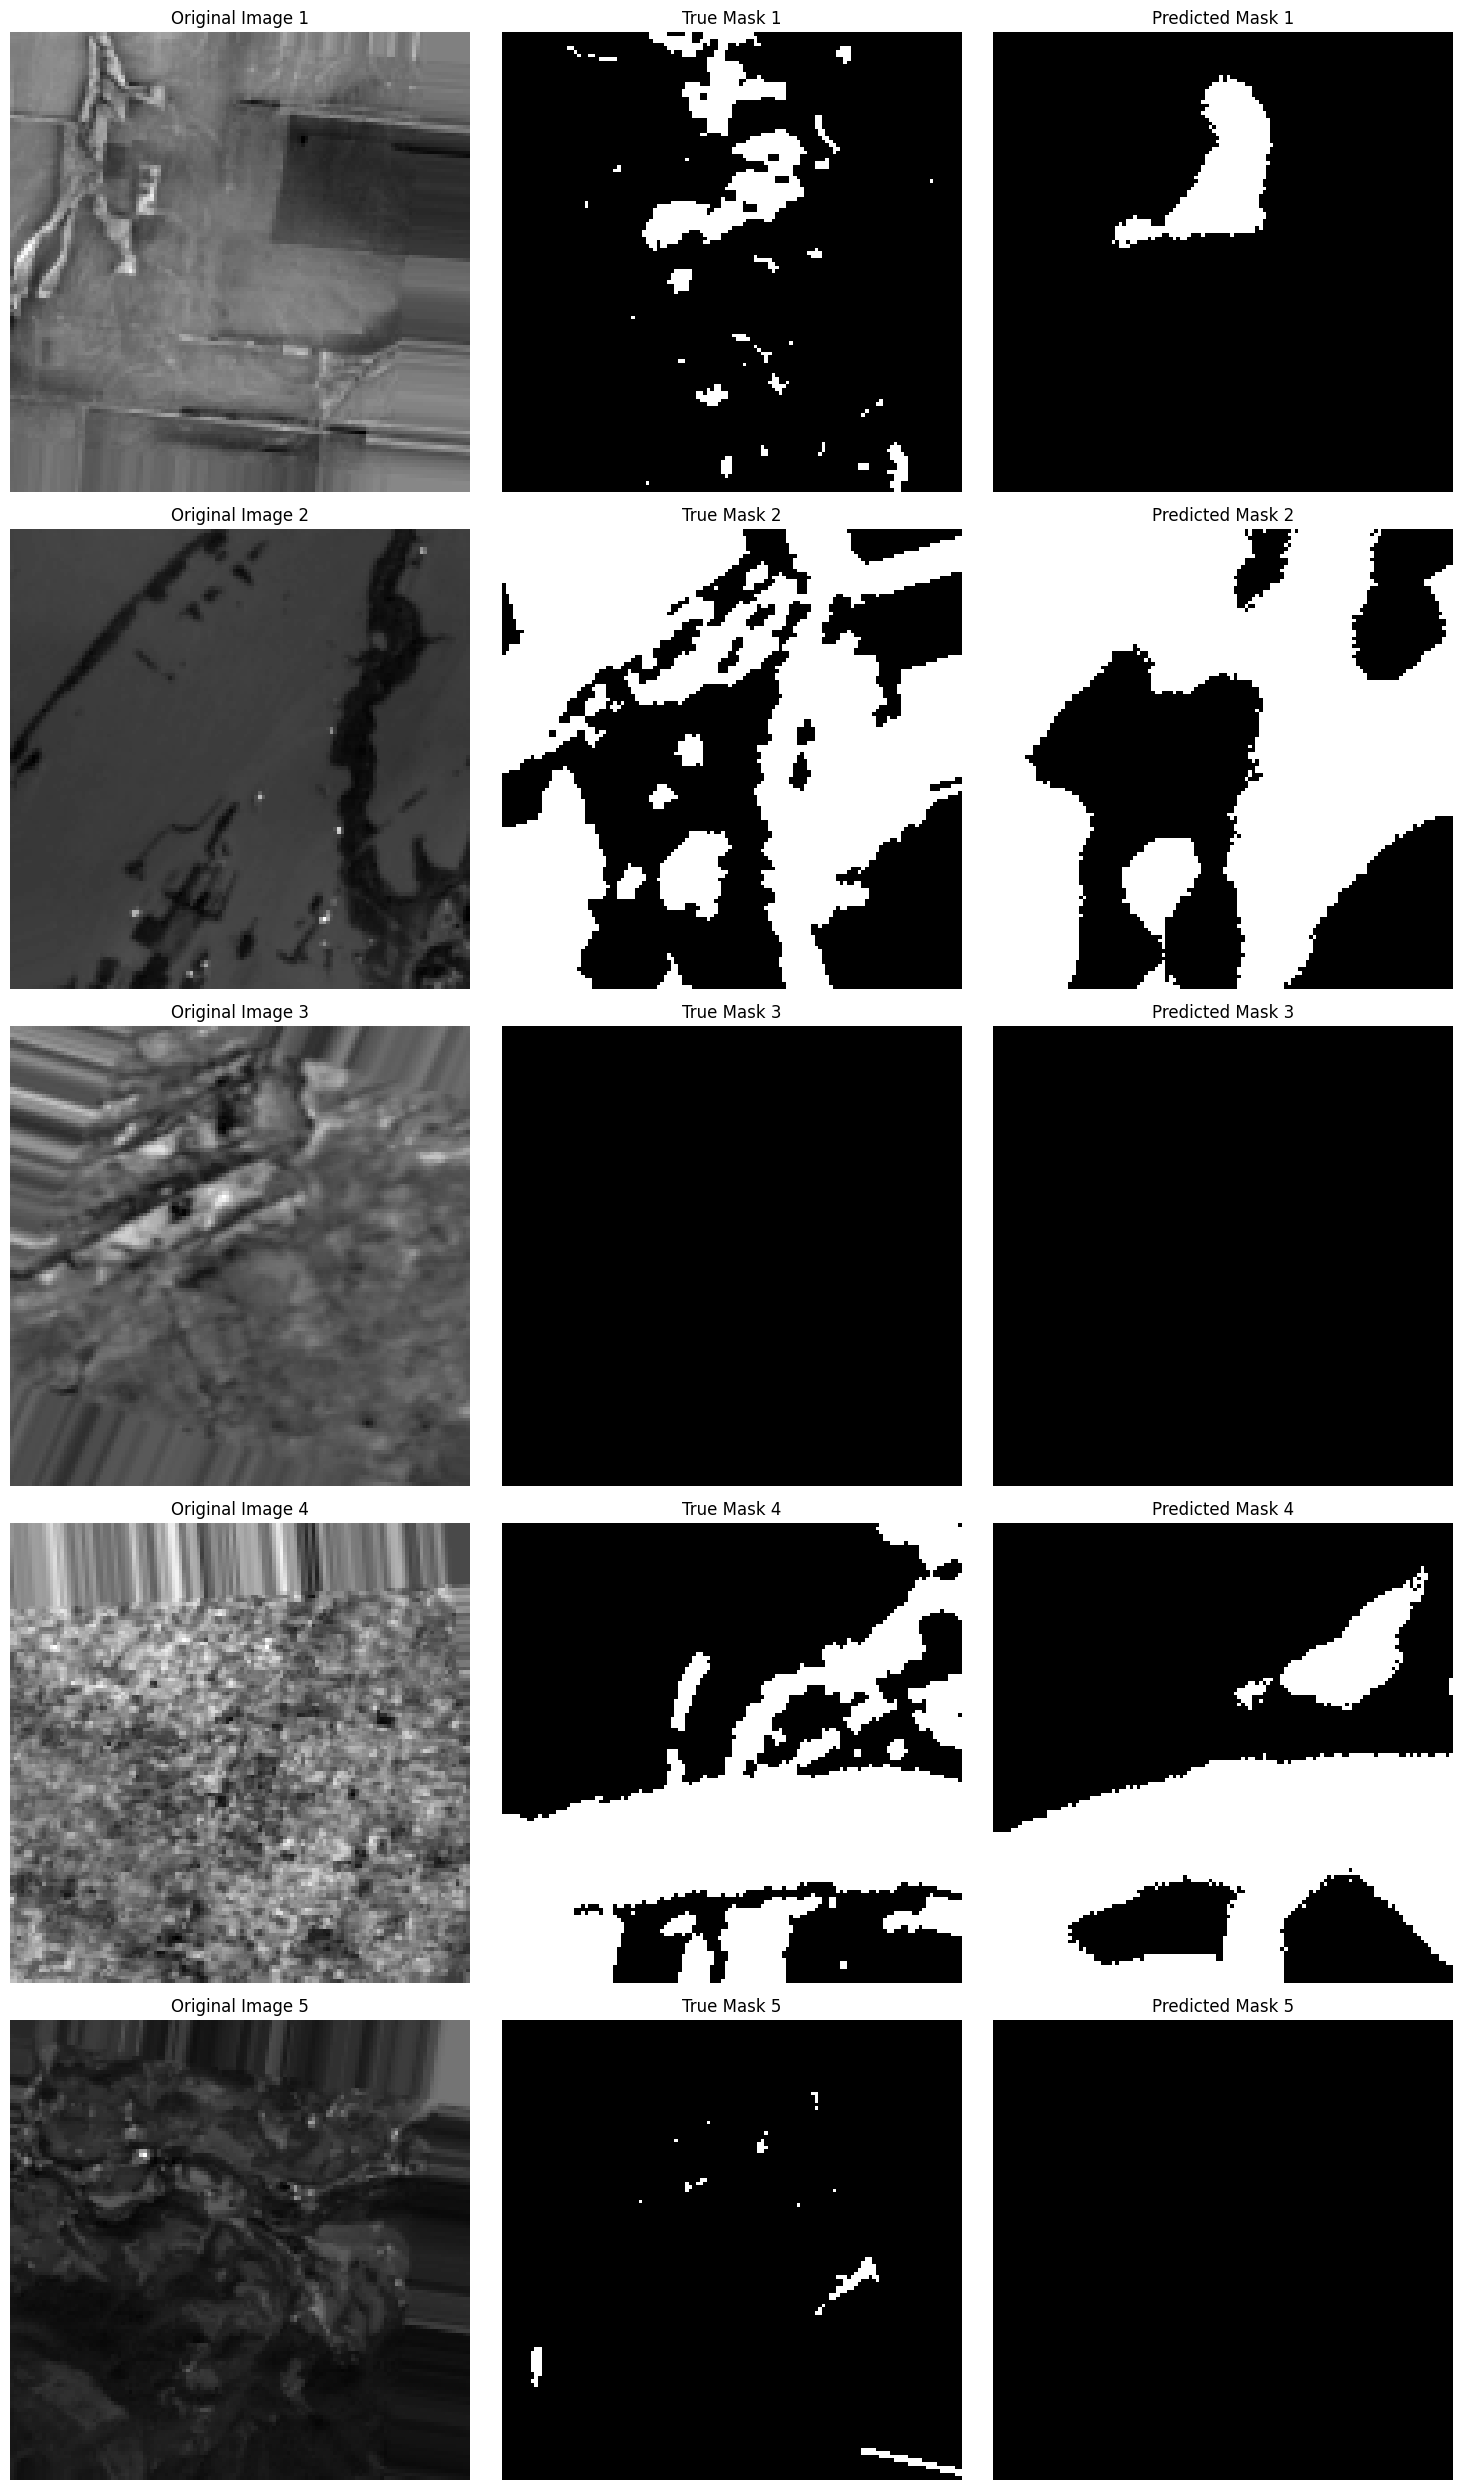

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_mask_prediction(original_images, true_masks, predicted_masks, num_images=3, threshold=0.5):
    num_images = min(num_images, len(original_images))  # Ensure num_images does not exceed available images
    plt.figure(figsize=(15, num_images * 5))  # Adjust figure size for better visibility

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i][:, :, 0], cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        if true_masks[i].ndim == 3:  # If multi-class (one-hot encoded)
            true_mask_display = np.argmax(true_masks[i], axis=-1)
        else:  # If binary
            true_mask_display = true_masks[i]
        plt.imshow(true_mask_display, cmap='gray')
        plt.title(f"True Mask {i+1}")
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        if predicted_masks.shape[-1] > 1:  # If multi-class, take argmax to get the class with highest probability
            predicted_mask_display = np.argmax(predicted_masks[i], axis=-1)
        else:  # If binary, threshold the single channel output
            predicted_mask_display = (predicted_masks[i] > threshold).astype(np.uint8)
        plt.imshow(predicted_mask_display, cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_image_mask_prediction(X_test[18:], y_test[10:], model.predict(X_test[10:]), num_images=5)
